In [ ]:
!pip install numpy pandas scikit-learn imbalanced-learn xgboost lightgbm

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/athlete_events.csv')

# Display the first few rows and data types
print(df.head())
print(df.info())

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

In [ ]:
import pandas as pd

#  Count medals separately for each country-year


medal_counts = (
    df.pivot_table(
        index=["NOC", "Year"],
        columns="Medal",
        values="ID",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)

# Rename columns safely (only if they exist)
medal_counts = medal_counts.rename(columns={
    "Gold": "Gold_Count",
    "Silver": "Silver_Count",
    "Bronze": "Bronze_Count"
})

# Ensure missing columns exist
for col in ["Gold_Count", "Silver_Count", "Bronze_Count"]:
    if col not in medal_counts:
        medal_counts[col] = 0

# -----------------------------------------
# 2) Create Top_Medal column (3/2/1/0)
# -----------------------------------------

def get_top_medal(row):
    if row["Gold_Count"] > 0:
        return 3
    elif row["Silver_Count"] > 0:
        return 2
    elif row["Bronze_Count"] > 0:
        return 1
    else:
        return 0

medal_counts["Top_Medal"] = medal_counts.apply(get_top_medal, axis=1)

# -----------------------------------------
# 3) Athlete participation counts
# -----------------------------------------

athlete_counts = (
    df.groupby(["NOC", "Year"])["ID"]
    .nunique()
    .reset_index()
    .rename(columns={"ID": "Athletes"})
)

# -----------------------------------------
# 4) Number of sports per country-year
# -----------------------------------------

sports_counts = (
    df.groupby(["NOC", "Year"])["Sport"]
    .nunique()
    .reset_index()
    .rename(columns={"Sport": "Num_Sports"})
)

# -----------------------------------------
# 5) Merge everything into a single dataset
# -----------------------------------------

country_year = (
    medal_counts
    .merge(athlete_counts, on=["NOC", "Year"], how="left")
    .merge(sports_counts, on=["NOC", "Year"], how="left")
)

# Fill missing
country_year["Athletes"] = country_year["Athletes"].fillna(0).astype(int)
country_year["Num_Sports"] = country_year["Num_Sports"].fillna(0).astype(int)

# Sort cleanly
country_year = country_year.sort_values(["NOC", "Year"]).reset_index(drop=True)

# -----------------------------------------
# 6) Final Output
# -----------------------------------------
print(country_year.head())
print(country_year.info())


   NOC  Year  Bronze_Count  Gold_Count  Silver_Count  Top_Medal  Athletes  \
0  AFG  2008             1           0             0          1         4   
1  AFG  2012             1           0             0          1         6   
2  AHO  1988             0           0             1          2         5   
3  ALG  1984             2           0             0          1        33   
4  ALG  1992             1           1             0          3        39   

   Num_Sports  
0           2  
1           4  
2           5  
3           4  
4           8  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NOC           1442 non-null   object
 1   Year          1442 non-null   int64 
 2   Bronze_Count  1442 non-null   int64 
 3   Gold_Count    1442 non-null   int64 
 4   Silver_Count  1442 non-null   int64 
 5   Top_Medal     1442 non-null   int64 

In [ ]:
import pandas as pd
import numpy as np

# Create MedalWon column
df['MedalWon'] = df['Medal'].apply(lambda x: 1 if pd.notna(x) and x != "None" else 0)

# Create medal_target: 1 row per NOC-Year-Event
medal_target = (
    df.groupby(['NOC', 'Year', 'Event'])['MedalWon']
    .max()
    .reset_index()
)


In [ ]:
merged_df = pd.merge(medal_target, df[['NOC', 'Year', 'Event', 'Sport', 'ID']],
                     on=['NOC', 'Year', 'Event'],
                     how='left')

# Drop duplicates that might arise from the merge if an event had multiple athletes from the same NOC in the same year
merged_df.drop_duplicates(subset=['NOC', 'Year', 'Event', 'Sport', 'ID'], inplace=True)

print(merged_df.head())
print(merged_df.info())

   NOC  Year                       Event  MedalWon      Sport     ID
0  AFG  1936  Athletics Men's 100 metres         0  Athletics  59161
1  AFG  1936   Athletics Men's Long Jump         0  Athletics  59161
2  AFG  1936    Athletics Men's Shot Put         0  Athletics  98340
3  AFG  1936         Hockey Men's Hockey         0     Hockey   1076
4  AFG  1936         Hockey Men's Hockey         0     Hockey   5582
<class 'pandas.core.frame.DataFrame'>
Index: 269636 entries, 0 to 271115
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   NOC       269636 non-null  object
 1   Year      269636 non-null  int64 
 2   Event     269636 non-null  object
 3   MedalWon  269636 non-null  int64 
 4   Sport     269636 non-null  object
 5   ID        269636 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 14.4+ MB
None
   NOC  Year                       Event  MedalWon      Sport     ID
0  AFG  1936  Athletics Men's 100 metres    

In [ ]:
athlete_counts = df.groupby(['NOC', 'Year', 'Event'])['ID'].nunique().reset_index(name='AthleteCount')

# Merge this new feature back into merged_df
merged_df = pd.merge(merged_df, athlete_counts, on=['NOC', 'Year', 'Event'], how='left')

print(merged_df.head())
print(merged_df.info())

   NOC  Year                       Event  MedalWon      Sport     ID  \
0  AFG  1936  Athletics Men's 100 metres         0  Athletics  59161   
1  AFG  1936   Athletics Men's Long Jump         0  Athletics  59161   
2  AFG  1936    Athletics Men's Shot Put         0  Athletics  98340   
3  AFG  1936         Hockey Men's Hockey         0     Hockey   1076   
4  AFG  1936         Hockey Men's Hockey         0     Hockey   5582   

   AthleteCount  
0             1  
1             1  
2             1  
3            13  
4            13  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269636 entries, 0 to 269635
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   NOC           269636 non-null  object
 1   Year          269636 non-null  int64 
 2   Event         269636 non-null  object
 3   MedalWon      269636 non-null  int64 
 4   Sport         269636 non-null  object
 5   ID            269636 non-null  int64 
 6   

In [ ]:
merged_df = pd.get_dummies(merged_df, columns=['Sport'], prefix='Sport')

print(merged_df.head())
print(merged_df.info())

   NOC  Year                       Event  MedalWon     ID  AthleteCount  \
0  AFG  1936  Athletics Men's 100 metres         0  59161             1   
1  AFG  1936   Athletics Men's Long Jump         0  59161             1   
2  AFG  1936    Athletics Men's Shot Put         0  98340             1   
3  AFG  1936         Hockey Men's Hockey         0   1076            13   
4  AFG  1936         Hockey Men's Hockey         0   5582            13   

   Sport_Aeronautics  Sport_Alpine Skiing  Sport_Alpinism  Sport_Archery  ...  \
0              False                False           False          False  ...   
1              False                False           False          False  ...   
2              False                False           False          False  ...   
3              False                False           False          False  ...   
4              False                False           False          False  ...   

   Sport_Table Tennis  Sport_Taekwondo  Sport_Tennis  Sport_Tr

In [ ]:
merged_df.sort_values(by=['NOC', 'Event', 'Year'], inplace=True)

print(merged_df.head())

     NOC  Year                       Event  MedalWon      ID  AthleteCount  \
0    AFG  1936  Athletics Men's 100 metres         0   59161             1   
53   AFG  1960  Athletics Men's 100 metres         0  109486             1   
106  AFG  1996  Athletics Men's 100 metres         0   39920             1   
108  AFG  2004  Athletics Men's 100 metres         0    6336             1   
113  AFG  2008  Athletics Men's 100 metres         0    6336             1   

     Sport_Aeronautics  Sport_Alpine Skiing  Sport_Alpinism  Sport_Archery  \
0                False                False           False          False   
53               False                False           False          False   
106              False                False           False          False   
108              False                False           False          False   
113              False                False           False          False   

     ...  Sport_Table Tennis  Sport_Taekwondo  Sport_Tennis  \

In [ ]:
for i in range(1, 4):
    merged_df[f'MedalWon_Lag{i}'] = merged_df.groupby(['NOC', 'Event'])['MedalWon'].shift(i)

print(merged_df.head())

     NOC  Year                       Event  MedalWon      ID  AthleteCount  \
0    AFG  1936  Athletics Men's 100 metres         0   59161             1   
53   AFG  1960  Athletics Men's 100 metres         0  109486             1   
106  AFG  1996  Athletics Men's 100 metres         0   39920             1   
108  AFG  2004  Athletics Men's 100 metres         0    6336             1   
113  AFG  2008  Athletics Men's 100 metres         0    6336             1   

     Sport_Aeronautics  Sport_Alpine Skiing  Sport_Alpinism  Sport_Archery  \
0                False                False           False          False   
53               False                False           False          False   
106              False                False           False          False   
108              False                False           False          False   
113              False                False           False          False   

     ...  Sport_Trampolining  Sport_Triathlon  Sport_Tug-Of-Wa

In [ ]:
merged_df['MedalWon_LagAvg'] = merged_df[['MedalWon_Lag1', 'MedalWon_Lag2', 'MedalWon_Lag3']].mean(axis=1)

print(merged_df.head())

     NOC  Year                       Event  MedalWon      ID  AthleteCount  \
0    AFG  1936  Athletics Men's 100 metres         0   59161             1   
53   AFG  1960  Athletics Men's 100 metres         0  109486             1   
106  AFG  1996  Athletics Men's 100 metres         0   39920             1   
108  AFG  2004  Athletics Men's 100 metres         0    6336             1   
113  AFG  2008  Athletics Men's 100 metres         0    6336             1   

     Sport_Aeronautics  Sport_Alpine Skiing  Sport_Alpinism  Sport_Archery  \
0                False                False           False          False   
53               False                False           False          False   
106              False                False           False          False   
108              False                False           False          False   
113              False                False           False          False   

     ...  Sport_Triathlon  Sport_Tug-Of-War  Sport_Volleyball 

**Reasoning**:
I will fill any `NaN` values in the lagged medal features ('MedalWon_Lag1', 'MedalWon_Lag2', 'MedalWon_Lag3', 'MedalWon_LagAvg') with 0, as these NaNs represent years where no prior medal history exists for that specific country and event.



In [ ]:
merged_df[['MedalWon_Lag1', 'MedalWon_Lag2', 'MedalWon_Lag3', 'MedalWon_LagAvg']] = merged_df[['MedalWon_Lag1', 'MedalWon_Lag2', 'MedalWon_Lag3', 'MedalWon_LagAvg']].fillna(0)

print(merged_df.head())
print(merged_df.info())

     NOC  Year                       Event  MedalWon      ID  AthleteCount  \
0    AFG  1936  Athletics Men's 100 metres         0   59161             1   
53   AFG  1960  Athletics Men's 100 metres         0  109486             1   
106  AFG  1996  Athletics Men's 100 metres         0   39920             1   
108  AFG  2004  Athletics Men's 100 metres         0    6336             1   
113  AFG  2008  Athletics Men's 100 metres         0    6336             1   

     Sport_Aeronautics  Sport_Alpine Skiing  Sport_Alpinism  Sport_Archery  \
0                False                False           False          False   
53               False                False           False          False   
106              False                False           False          False   
108              False                False           False          False   
113              False                False           False          False   

     ...  Sport_Triathlon  Sport_Tug-Of-War  Sport_Volleyball 

In [ ]:
X = merged_df.drop(columns=['MedalWon', 'NOC', 'Year', 'Event', 'ID'])
y = merged_df['MedalWon']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (269636, 71)
Shape of y: (269636,)
Shape of X: (269636, 71)
Shape of y: (269636,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (215708, 71)
Shape of y_train: (215708,)
Shape of X_test: (53928, 71)
Shape of y_test: (53928,)
Shape of X_train: (215708, 71)
Shape of y_train: (215708,)
Shape of X_test: (53928, 71)
Shape of y_test: (53928,)


In [ ]:
from sklearn.preprocessing import StandardScaler

print("StandardScaler imported successfully.")

StandardScaler imported successfully.
StandardScaler imported successfully.


In [ ]:
numerical_cols = ['AthleteCount', 'MedalWon_Lag1', 'MedalWon_Lag2', 'MedalWon_Lag3', 'MedalWon_LagAvg']

scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Numerical columns in X_train after scaling:")
print(X_train[numerical_cols].head())
print("Numerical columns in X_test after scaling:")
print(X_test[numerical_cols].head())

Numerical columns in X_train after scaling:
        AthleteCount  MedalWon_Lag1  MedalWon_Lag2  MedalWon_Lag3  \
151731     -0.446815      -0.496313      -0.479469      -0.464452   
228424      0.789989      -0.496313      -0.479469      -0.464452   
61420      -0.171970      -0.496313      -0.479469      -0.464452   
135679      0.377721      -0.496313      -0.479469      -0.464452   
134678      0.652566      -0.496313      -0.479469      -0.464452   

        MedalWon_LagAvg  
151731        -0.531042  
228424        -0.531042  
61420         -0.531042  
135679        -0.531042  
134678        -0.531042  
Numerical columns in X_test after scaling:
        AthleteCount  MedalWon_Lag1  MedalWon_Lag2  MedalWon_Lag3  \
114002     -0.446815      -0.496313      -0.479469      -0.464452   
69795       1.064834       2.014857       2.085642      -0.464452   
57519       1.477102      -0.496313      -0.479469      -0.464452   
72710      -0.446815      -0.496313      -0.479469      -0.464452 

In [ ]:
from imblearn.over_sampling import SMOTE

print("SMOTE imported successfully.")

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print(f"Original X_train shape: {X_train.shape}")
print(f"Original y_train shape: {y_train.shape}")
print(f"Resampled X_train shape: {X_train_resampled.shape}")
print(f"Resampled y_train shape: {y_train_resampled.shape}")

SMOTE imported successfully.
Original X_train shape: (215708, 71)
Original y_train shape: (215708,)
Resampled X_train shape: (341368, 71)
Resampled y_train shape: (341368,)
SMOTE imported successfully.
Original X_train shape: (215708, 71)
Original y_train shape: (215708,)
Resampled X_train shape: (341368, 71)
Resampled y_train shape: (341368,)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_resampled)
X_test_poly = poly.transform(X_test)

print(f"Shape of X_train_poly: {X_train_poly.shape}")
print(f"Shape of X_test_poly: {X_test_poly.shape}")

Shape of X_train_poly: (341368, 2627)
Shape of X_test_poly: (53928, 2627)


In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

print("All necessary classifier classes imported successfully.")

All necessary classifier classes imported successfully.


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost Classifier': XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, n_estimators=100),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'LightGBM Classifier': LGBMClassifier(random_state=42, n_estimators=100),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=42, n_estimators=100),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Extra Trees Classifier': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000),
    'SVM Classifier': SVC(random_state=42, gamma='auto'),
    'Polynomial Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

trained_models = {}

# Train models
print("Starting model training...")
for name, model in models.items():
    if name == 'Polynomial Logistic Regression':
        print(f"Training {name}...")
        model.fit(X_train_poly, y_train_resampled)
    elif name == 'SVM Classifier':
        print(f"Training {name} (using a subset for performance)...")
        # Use a smaller subset for SVM due to high computational cost
        model.fit(X_train_resampled[::100], y_train_resampled[::100])
    else:
        print(f"Training {name}...")
        model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model
    print(f"{name} trained successfully.")

print("All models trained.")


Starting model training...
Training Logistic Regression...
Logistic Regression trained successfully.
Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:04:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier trained successfully.
Training Random Forest Classifier...
Random Forest Classifier trained successfully.
Training KNeighbors Classifier...
KNeighbors Classifier trained successfully.
Training Gaussian Naive Bayes...
Gaussian Naive Bayes trained successfully.
Training LightGBM Classifier...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 170684, number of negative: 170684
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 341368, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classifier trained successfully.
Training AdaBoost Classifier...
AdaBoost Classifier trained su

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

model_performance = {}

print("Evaluating model performance...")
for name, model in trained_models.items():
    if name == 'Polynomial Logistic Regression':
        y_pred = model.predict(X_test_poly)
    elif name == 'SVM Classifier':
        # Given SVM was trained on a subset, predicting on the full test set can be slow.
        # However, for a proper evaluation, we attempt to predict on the full X_test.
        # If it's too slow, a future step might need to adjust.
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    print(f"Finished evaluating {name}.")

# Display the performance results
for name, metrics in model_performance.items():
    print(f"\n--- {name} ---")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Create a list of lists from model_performance dictionary to create the DataFrame
results = []
for name, metrics in model_performance.items():
    results.append([name, metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1-Score']])

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-Score"])
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\n\n============= FINAL MODEL PERFORMANCE TABLE =============\n")
print(results_df.to_string(index=False))

Evaluating model performance...
Finished evaluating Logistic Regression.
Finished evaluating XGBoost Classifier.
Finished evaluating Random Forest Classifier.
Finished evaluating KNeighbors Classifier.
Finished evaluating Gaussian Naive Bayes.
Finished evaluating LightGBM Classifier.
Finished evaluating AdaBoost Classifier.
Finished evaluating Decision Tree Classifier.
Finished evaluating Extra Trees Classifier.
Finished evaluating Gradient Boosting Classifier.
Finished evaluating MLP Classifier.
Finished evaluating SVM Classifier.
Finished evaluating Polynomial Logistic Regression.

--- Logistic Regression ---
Accuracy: 0.9339
Precision: 0.8566
Recall: 0.8163
F1-Score: 0.8360

--- XGBoost Classifier ---
Accuracy: 0.9329
Precision: 0.8488
Recall: 0.8212
F1-Score: 0.8347

--- Random Forest Classifier ---
Accuracy: 0.9314
Precision: 0.8403
Recall: 0.8245
F1-Score: 0.8323

--- KNeighbors Classifier ---
Accuracy: 0.9317
Precision: 0.8900
Recall: 0.7633
F1-Score: 0.8218

--- Gaussian Naive 

In [ ]:

# CELL 13

# Drop rows with missing values (if any)
clean_df = results_df.dropna(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# 1. Sort the DataFrame by F1-Score (descending)
results_df_sorted = clean_df.sort_values(by='F1-Score', ascending=False)

# 2. Select the best model (first row)
best_model = results_df_sorted.iloc[0]

# 3. Print best model and scores
print("-----------------------------------")
print(f"🏅 Best Model: {best_model['Model']}")
print(f"Accuracy : {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall   : {best_model['Recall']:.4f}")
print(f"F1 Score : {best_model['F1-Score']:.4f}")
print("-----------------------------------")

-----------------------------------
🏅 Best Model: AdaBoost Classifier
Accuracy : 0.9344
Precision: 0.8592
Recall   : 0.8158
F1 Score : 0.8369
-----------------------------------


/tmp/ipython-input-4100504889.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df.sort_values(by='Accuracy', ascending=False), palette='viridis')


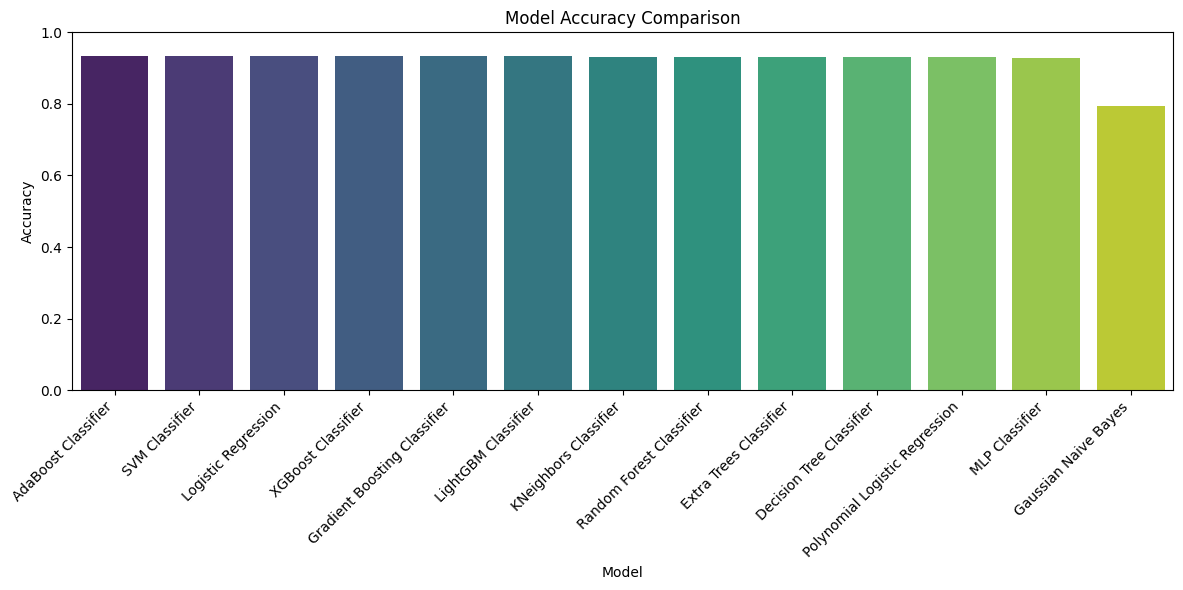

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df.sort_values(by='Accuracy', ascending=False), palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.tight_layout()
plt.show()

/tmp/ipython-input-1253495983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results_df.sort_values(by='Precision', ascending=False), palette='magma')


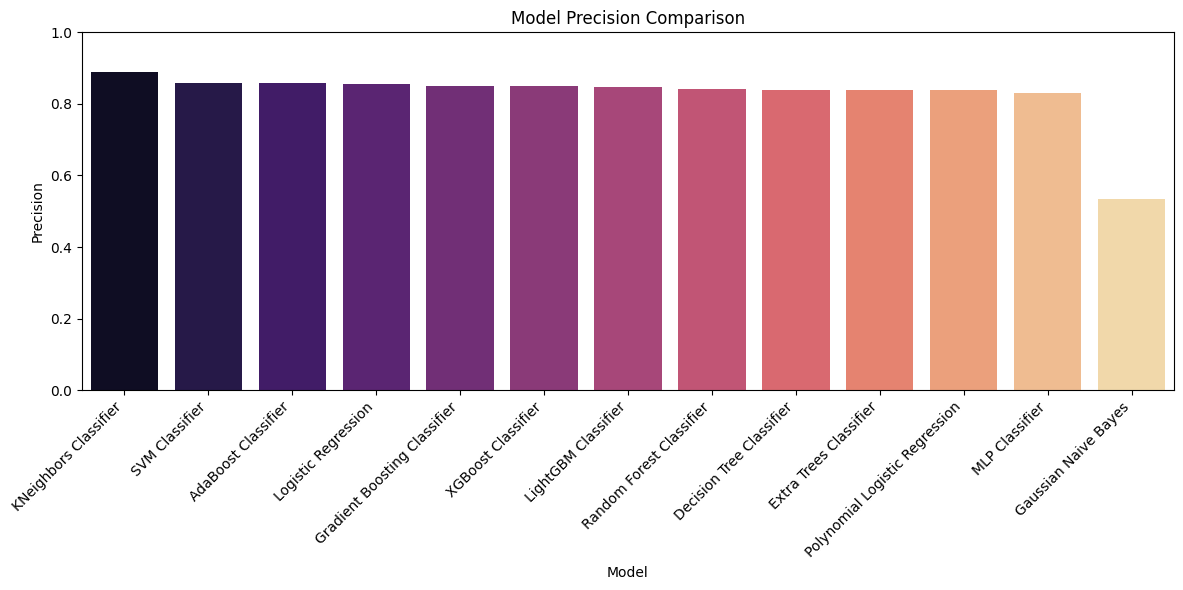

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Precision', data=results_df.sort_values(by='Precision', ascending=False), palette='magma')
plt.title('Model Precision Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Precision is between 0 and 1
plt.tight_layout()
plt.show()

Generating ROC curves...
  ROC curve generated for Logistic Regression.
  ROC curve generated for XGBoost Classifier.
  ROC curve generated for Random Forest Classifier.
  ROC curve generated for KNeighbors Classifier.
  ROC curve generated for Gaussian Naive Bayes.
  ROC curve generated for LightGBM Classifier.
  ROC curve generated for AdaBoost Classifier.
  ROC curve generated for Decision Tree Classifier.
  ROC curve generated for Extra Trees Classifier.
  ROC curve generated for Gradient Boosting Classifier.
  ROC curve generated for MLP Classifier.
  Skipping SVM Classifier: predict_proba method not available or model not suitable for ROC curve.
  ROC curve generated for Polynomial Logistic Regression.


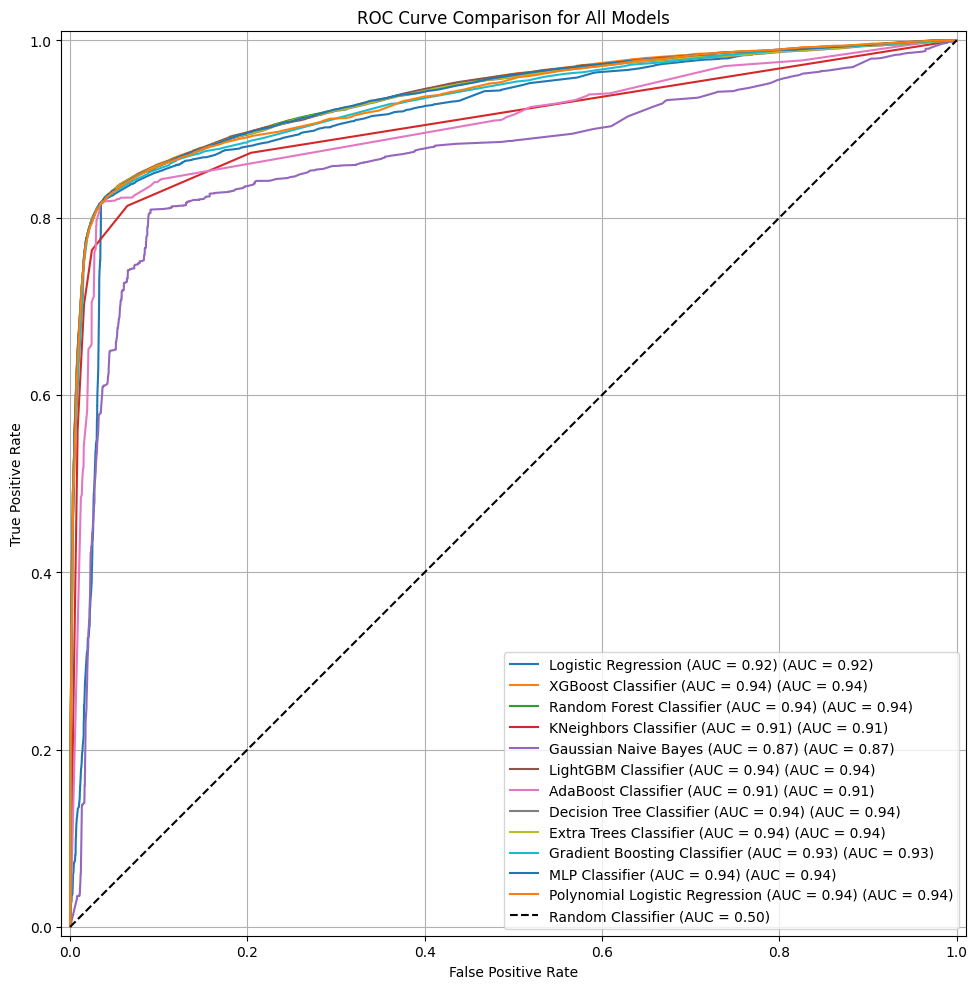

All ROC curves generated and displayed.


In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

print("Generating ROC curves...")
for name, model in trained_models.items():
    try:
        if name == 'Polynomial Logistic Regression':
            y_pred_proba = model.predict_proba(X_test_poly)[:, 1]
        elif name == 'SVM Classifier':
            # SVM's predict_proba can be slow, but it's needed for ROC curve. Will run on full X_test.
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif name == 'Gaussian Naive Bayes':
            # Gaussian Naive Bayes was trained on X_train_resampled, so predicting on X_test
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute AUC
        auc = roc_auc_score(y_test, y_pred_proba)

        # Plot ROC curve
        RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=f'{name} (AUC = {auc:.2f})', ax=plt.gca())
        print(f"  ROC curve generated for {name}.")

    except AttributeError:
        print(f"  Skipping {name}: predict_proba method not available or model not suitable for ROC curve.")
    except Exception as e:
        print(f"  Error generating ROC curve for {name}: {e}")

plt.title('ROC Curve Comparison for All Models')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
print("All ROC curves generated and displayed.")

/tmp/ipython-input-3489385580.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=results_df.sort_values(by='F1-Score', ascending=False), palette='rocket')


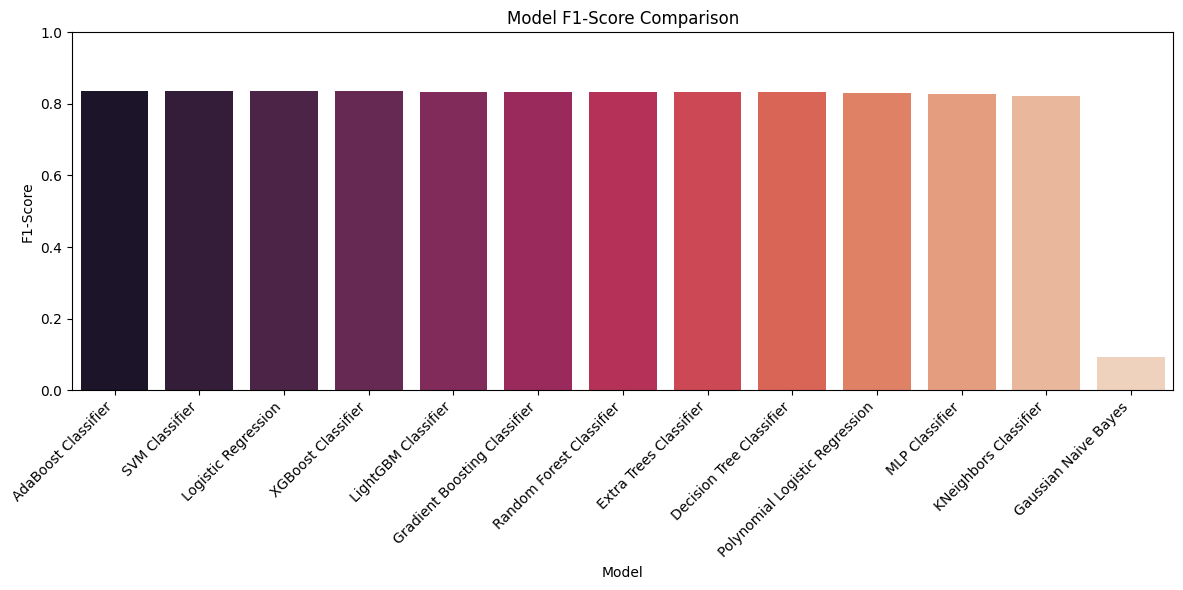

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', data=results_df.sort_values(by='F1-Score', ascending=False), palette='rocket')
plt.title('Model F1-Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # F1-Score is between 0 and 1
plt.tight_layout()
plt.show()

In [ ]:
medal_map = {
    3: "Gold",
    2: "Silver",
    1: "Medal Won",
    0: "No Medal"
}


In [ ]:
feature_cols = [
    "AthleteCount",
    "MedalWon_Lag1",
    "MedalWon_Lag2",
    "MedalWon_Lag3",
    "MedalWon_LagAvg"
]


In [ ]:


def predict_medal(athlete_count, sport, medal_lag1, medal_lag2, medal_lag3, model, scaler, poly_features, sport_cols_in_X_test):
    # Create a hypothetical DataFrame for the input
    hypothetical_data_raw = {
        'AthleteCount': [athlete_count],
        'MedalWon_Lag1': [medal_lag1],
        'MedalWon_Lag2': [medal_lag2],
        'MedalWon_Lag3': [medal_lag3],
        'MedalWon_LagAvg': [(medal_lag1 + medal_lag2 + medal_lag3) / 3.0]
    }
    hypothetical_df = pd.DataFrame(hypothetical_data_raw)

    # Scale numerical features
    numerical_cols = ['AthleteCount', 'MedalWon_Lag1', 'MedalWon_Lag2', 'MedalWon_Lag3', 'MedalWon_LagAvg']
    hypothetical_df[numerical_cols] = scaler.transform(hypothetical_df[numerical_cols])

    # One-hot encode the sport
    hypothetical_sport_encoded = pd.DataFrame(0, index=hypothetical_df.index, columns=sport_cols_in_X_test)
    if 'Sport_' + sport in hypothetical_sport_encoded.columns:
        hypothetical_sport_encoded['Sport_' + sport] = 1

    # Combine all features
    hypothetical_input = pd.concat([
        hypothetical_df.drop(columns=['MedalWon_LagAvg']),
        hypothetical_sport_encoded,
        hypothetical_df[['MedalWon_LagAvg']]
    ], axis=1)

    # Ensure column order matches X_test
    # This part assumes X_test has the correct order and columns
    # It's crucial for correct prediction.
    # Let's rebuild the input based on X_test columns to ensure order and presence
    final_hypothetical_input = pd.DataFrame(columns=X_test.columns)
    for col in X_test.columns:
        if col in hypothetical_input.columns:
            final_hypothetical_input[col] = hypothetical_input[col]
        else:
            final_hypothetical_input[col] = 0 # Default to 0 for missing columns, e.g., other sports

    # Convert boolean columns to int if necessary for poly_features
    for col in final_hypothetical_input.select_dtypes(include='bool').columns:
        final_hypothetical_input[col] = final_hypothetical_input[col].astype(int)

    # Apply polynomial features if the model requires it
    if 'Polynomial' in model.__class__.__name__ or 'poly_features' in str(model): # Heuristic check for polynomial models
        hypothetical_input_for_model = poly_features.transform(final_hypothetical_input)
    else:
        hypothetical_input_for_model = final_hypothetical_input

    # Predict
    prediction = model.predict(hypothetical_input_for_model)[0]
    confidence_score = model.predict_proba(hypothetical_input_for_model)[0][1] # Probability of winning a medal

    medal_status = medal_map[prediction]

    return medal_status, confidence_score

print("predict_medal function defined.")

predict_medal function defined.


In [ ]:


while True:
    try:
        user_athlete_count = int(input("Enter athlete count (integer): "))
        if user_athlete_count < 0:
            print("Athlete count cannot be negative. Please try again.")
            continue
        break
    except ValueError:
        print("Invalid input. Please enter an integer for athlete count.")

user_sport = input("Enter sport (e.g., 'Athletics', 'Swimming'): ")

# --- START OF ADDED COUNTRY INPUT ---
user_country = input("Enter country (e.g., 'USA', 'CHN'): ")
# --- END OF ADDED COUNTRY INPUT ---

while True:
    try:
        user_medal_lag1 = int(input("Enter medal status for previous year (1 for medal, 0 for no medal): "))
        if user_medal_lag1 not in [0, 1]:
            print("Invalid input. Please enter 0 or 1.")
            continue
        break
    except ValueError:
        print("Invalid input. Please enter an integer (0 or 1).")

while True:
    try:
        user_medal_lag2 = int(input("Enter medal status for two years prior (1 for medal, 0 for no medal): "))
        if user_medal_lag2 not in [0, 1]:
            print("Invalid input. Please enter 0 or 1.")
            continue
        break
    except ValueError:
        print("Invalid input. Please enter an integer (0 or 1).")

while True:
    try:
        user_medal_lag3 = int(input("Enter medal status for three years prior (1 for medal, 0 for no medal): "))
        if user_medal_lag3 not in [0, 1]:
            print("Invalid input. Please enter 0 or 1.")
            continue
        break
    except ValueError:
        print("Invalid input. Please enter an integer (0 or 1).")

# Get the best model (AdaBoost Classifier) and necessary preprocessing components
best_model_name = results_df_sorted.iloc[0]['Model']
best_model = trained_models[best_model_name]

sport_cols = [col for col in X.columns if col.startswith('Sport_')]

# Call the predict_medal function with user inputs
user_prediction_result, user_confidence_score = predict_medal(
    user_athlete_count,
    user_sport,
    user_medal_lag1,
    user_medal_lag2,
    user_medal_lag3,
    best_model,
    scaler,
    poly,
    sport_cols
)

# Display the user-defined prediction
print(f"\n--- Your Custom Prediction Result ---")
# --- UPDATED PRINT STATEMENT ---
print(f"Scenario: {user_athlete_count} athletes in {user_sport} for {user_country}, with lagged medals: {user_medal_lag1}, {user_medal_lag2}, {user_medal_lag3}")
# -------------------------------
print(f"Predicted Medal Outcome: {user_prediction_result}")
print(f"Confidence Score (probability of 'Medal Won'): {user_confidence_score:.4f}")

Enter athlete count (integer): 2
Enter sport (e.g., 'Athletics', 'Swimming'): Athletics
Enter country (e.g., 'USA', 'CHN'): USA
Enter medal status for previous year (1 for medal, 0 for no medal): 1
Enter medal status for two years prior (1 for medal, 0 for no medal): 0
Enter medal status for three years prior (1 for medal, 0 for no medal): 0

--- Your Custom Prediction Result ---
Scenario: 2 athletes in Athletics for USA, with lagged medals: 1, 0, 0
Predicted Medal Outcome: Medal Won
Confidence Score (probability of 'Medal Won'): 0.7342
